# Results

### Uploading the experiment files

In [92]:
import os
import json
import sys

import pandas as pd
import numpy as np

from openqaoa.algorithms import QAOAResult
import matplotlib.pyplot as plt
from matplotlib import rcParams
#Parametros para graficas
#plt.style.use('dark_background')
rcParams.update( {'xtick.labelsize': 15, 'ytick.labelsize': 15, 'font.size': 18} )

from scipy.stats import norm,stats
from scipy.ndimage import zoom

sys.path.append(os.path.abspath(os.path.join('../..', 'functions')))
from JRPClassic import JRPClassic
from utils import *

In [93]:
files ={}
directory = './results'

for file in os.listdir(directory):
    if file.endswith('.json'):
        full_path = os.path.join(directory, file)
        with open(full_path, 'r', encoding='utf-8') as f:
            filename = os.path.splitext(file)[0]
            files[filename] = json.load(f)

In [94]:
keys = list(files.keys())

### Presenting the files

There is a total of 21 files, where each has a corresponding JRP initialization configuration and circuit configuration. Each file has a sample of 5 instances, resulting in a total sample of $5 \cdot 21 = 105$ JRP instances.

Apart from its file name, a configuration is defined as a tuple $(a,v,p)$, where $a$ is the number of agents, $v$ is the number of vacant jobs and $p$ is the corresponding hyperparameter of a QAOA ansatz.

In [111]:
dfs = []
configurations_names = []
for filename, data in files.items():
    # Extract specific data based on keys_to_extract
    jrp_configuration = data['jrp_configuration']
    circuit_configuration = data['circuit_configuration']

    num_agents = jrp_configuration['num_agents']
    num_vacnJobs = jrp_configuration['num_vacnJobs']
    p = circuit_configuration['p']
    configuration_name = f'({num_agents},{num_vacnJobs},{p})'
    configurations_names.append(configuration_name)
    
    row = {'file_name':filename,'configuration':configuration_name,**jrp_configuration,**circuit_configuration}
    
    columns = ['file_name','configuration']+list(jrp_configuration.keys()) + list(circuit_configuration.keys())
    
    # Convert the extracted data into a DataFrame
    pd.set_option('display.width', 1000)  # Set a large width to prevent wrapping
    df = pd.DataFrame([[row.get(col) for col in columns]],columns=columns)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.index = df.index + 1

df
#df.to_csv('results/csvs/files_and_configurations.csv')

,file_name,configuration,num_agents,num_vacnJobs,penalty1,penalty2,control_restrictions,p,param_type,init_type,mixer_hamiltonian
1,conf_jrpInitConf0_circuitConf0,"(5,3,3)",5,3,2.5,3,False,3,standard,ramp,x
2,conf_jrpInitConf0_circuitConf1,"(5,3,4)",5,3,2.5,3,False,4,standard,ramp,x
3,conf_jrpInitConf0_circuitConf2,"(5,3,5)",5,3,2.5,3,False,5,standard,ramp,x
4,conf_jrpInitConf1_circuitConf0,"(3,5,3)",3,5,2.5,3,False,3,standard,ramp,x
5,conf_jrpInitConf1_circuitConf1,"(3,5,4)",3,5,2.5,3,False,4,standard,ramp,x
6,conf_jrpInitConf1_circuitConf2,"(3,5,5)",3,5,2.5,3,False,5,standard,ramp,x
7,conf_jrpInitConf2_circuitConf0,"(6,3,3)",6,3,2.5,3,False,3,standard,ramp,x
8,conf_jrpInitConf2_circuitConf1,"(6,3,4)",6,3,2.5,3,False,4,standard,ramp,x
9,conf_jrpInitConf2_circuitConf2,"(6,3,5)",6,3,2.5,3,False,5,standard,ramp,x
10,conf_jrpInitConf3_circuitConf0,"(3,6,3)",3,6,2.5,3,False,3,standard,ramp,x


### Approximation ratio

We will read the approximation ratio for each (file,sample). The structure saved is a list where an element (i,j) corresponds to file i and sample j.

In [213]:
approximation_ratios = []

instances_indexes = range(5)
for file_index,(filename,data) in enumerate(files.items()):
    approximation_ratios.append([])
    
    for instance_index in instances_indexes:
        approximation_ratios[file_index].append(data[str(instance_index)]['approximation_ratio'])

Some hyperparameters for visualization.

In [214]:
np.random.seed(0)
data = np.array(approximation_ratios)

nums_files = data.shape[0]
first_files = nums_files // 2
last_files =  nums_files - nums_files // 2
num_samples_per_file = data.shape[1]

We define a set of colors for some of the following plots.

In [215]:
colors_reds = plt.cm.Reds(np.linspace(0.3, 0.9, num_samples_per_file))
colors_blues = plt.cm.Blues(np.linspace(0.3, 0.9, num_samples_per_file))
colors_greens = plt.cm.Greens(np.linspace(0.3, 0.9, num_samples_per_file))
colors_purples = plt.cm.Purples(np.linspace(0.3, 0.9, num_samples_per_file))
colors_oranges = plt.cm.Oranges(np.linspace(0.3, 0.9, num_samples_per_file))
colors_greys = plt.cm.Greys(np.linspace(0.3, 0.9, num_samples_per_file))
colors_pinks = plt.cm.BuGn(np.linspace(0.3, 0.9, num_samples_per_file))
colors_cool = plt.cm.OrRd(np.linspace(0.3, 0.9, num_samples_per_file))
colors_copper = plt.cm.PuBu(np.linspace(0.3, 0.9, num_samples_per_file))
colors_viridis = plt.cm.viridis(np.linspace(0.3, 0.9, num_samples_per_file))
colors_magma = plt.cm.magma(np.linspace(0.3, 0.9, num_samples_per_file))
colors = np.array([colors_reds,colors_blues,colors_greens,colors_purples,colors_oranges,colors_greys,colors_pinks,colors_cool,colors_copper,colors_viridis,colors_magma])

The following plot groups the instances sampled per configuration, and show for each one, its corresponding approximation ratio. As a first result, it can be seen that most of the instances has succesful approximation ratio, since no one of them has a ratio lower than $0.6$, and most of them seems to variate in the range between $0.7$ to $1$.

C:\Users\Adriano\AppData\Local\Temp\ipykernel_4020\2813204666.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(np.arange(first_files)[j] * category_width  + i * bar_width / num_samples_per_file,  # Desplazamiento de los puntos


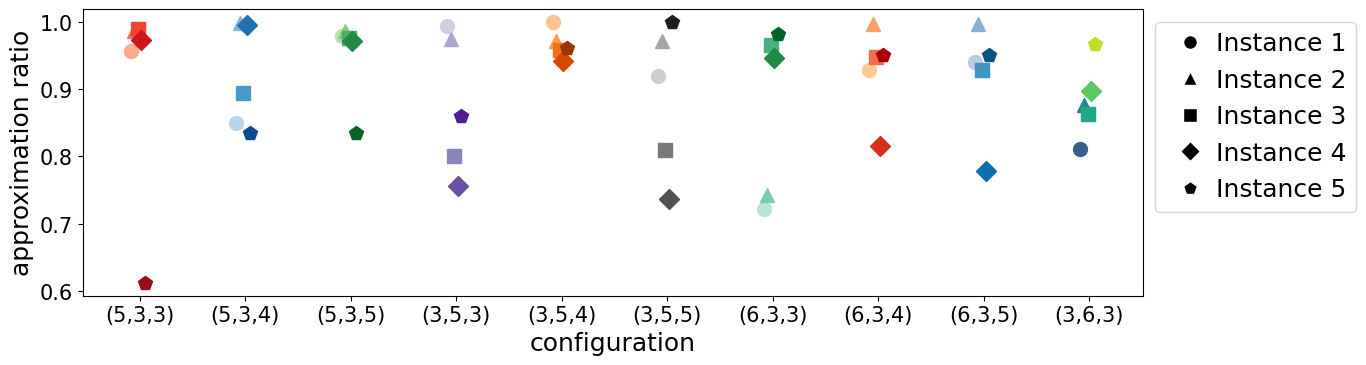

C:\Users\Adriano\AppData\Local\Temp\ipykernel_4020\2813204666.py:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(np.arange(last_files)[j] * category_width  + i * bar_width / num_samples_per_file,


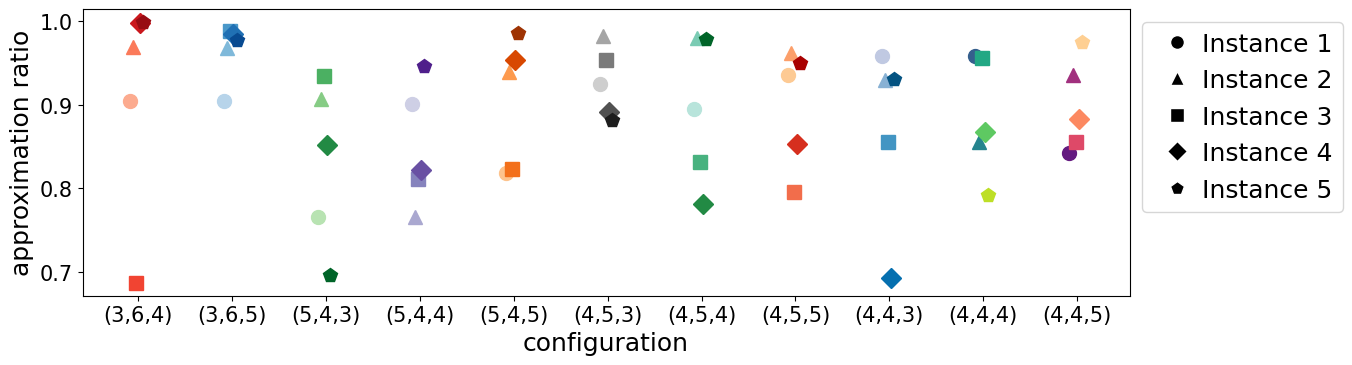

In [216]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(14, 4))
markers = ['o', '^', 's', 'D', 'p']  
linestyles = ['-', '--', '-.', ':']  
bar_width = 0.5
category_width = 3  

xlabel = 'configuration'
ylabel = 'approximation ratio'
title = 'Approximation ratio for the JRP instances of all configurations'

# Plot bars for each group
for i in range(num_samples_per_file):
    for j in range(0,first_files):
        ax.plot(np.arange(first_files)[j] * category_width  + i * bar_width / num_samples_per_file,  # Desplazamiento de los puntos
            data[j, i],
            'o', 
            color=colors[j][i],
            marker=markers[i],
            markersize=10,
            label=f'Group {i+1}')

# Add labels, title, and legend
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
legend_elements = [plt.Line2D([0], [0], marker=markers[i], color='w', label=f'Instance {i+1}', 
                              markerfacecolor='k', markersize=10) for i in range(num_samples_per_file)]
ax.legend(handles=legend_elements,  loc='upper left', bbox_to_anchor=(1, 1),handletextpad=0.01)
plt.xticks(np.arange(first_files) * category_width  + bar_width / 2, labels=[f'{configurations_names[i]}' for i in range(first_files)])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 4))
for i in range(num_samples_per_file):
    for j in range(last_files):
        ax.plot(np.arange(last_files)[j] * category_width  + i * bar_width / num_samples_per_file, 
            data[first_files+j, i],
            'o', 
            color=colors[j][i],
            marker=markers[i],
            markersize=10,
            label=f'Group {i+1}')

# Add labels, title, and legend
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend(handles=legend_elements,  loc='upper left', bbox_to_anchor=(1, 1),handletextpad=0.01)


plt.xticks(np.arange(last_files) * category_width  + bar_width / 2, [f'{configurations_names[i]}' for i in  range(last_files-1,nums_files)])
#ax.set_yticks(np.arange(0, 1.1, 0.1) )
plt.tight_layout()
plt.show()

In [217]:
column_names = ['Instance 1', 'Instance 2', 'Instance 3', 'Instance 4', 'Instance 5']
df = pd.DataFrame(data,columns=column_names)
df.insert(0,'configuration',configurations_names)
df.to_csv('results/csvs/approximation_ratio/approximation_ratio_per_configuration.csv')

The following plot show statistics of approximation ratio for different instances groups. These groups are form depending the JRP configuration used. That means, the amount of agent and vancancy jobs assigned to the problem. There is no important discussion here.

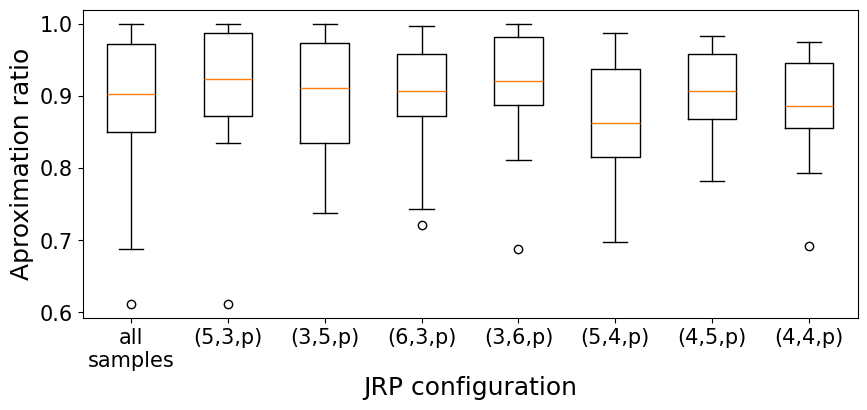

In [218]:
subdatas = [data.flatten()]
for index in range(0,len(data),3):
    subdatas.append(np.concatenate((data[index],data[index+1],data[index+2])))

means = [np.mean(subdata, axis=0) for subdata in subdatas]

plt.figure(figsize=(10, 4))
categories =  ['all\nsamples','(5,3,p)','(3,5,p)',
               '(6,3,p)','(3,6,p)',
               '(5,4,p)','(4,5,p)',
               '(4,4,p)']

plt.boxplot(subdatas,labels=categories,usermedians=means)

plt.xlabel('JRP configuration')
plt.ylabel('Aproximation ratio')

plt.show()

The following plot show statistics of approximation ratio for different instances group. These groups are form depending the circuit width. It is important to remember that the circuit width is going to be the product between the amount of agent and the amount of vacancy jobs. Usually, in QAOA, a bigger circuit with will be related to a bigger circuit depth. Because using more qubits means using more variables, it will also been translated to a larger cost hamiltonian.

For larger problem (and by that, circuit depth and width) eithera bigger p value and bigger amount of optimization steps would be needed. This makes sense with the results show below. It can be seen that, the bigger the circuit width, the smaller is the meadian approximation ratio. There is a much noticed decrease in performance when jumping from a width of 18 to 20. The median decrease is even larger, and also, the $q1-q3$ interval shift to lower values.  

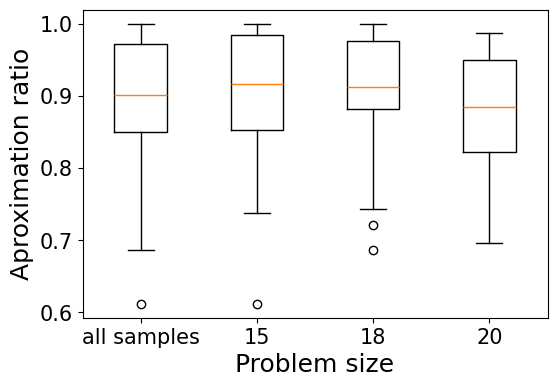

In [219]:
subdatas = [data.flatten()]
for index in range(0,len(data)-6,6):
    subdatas.append(np.concatenate((data[index],data[index+1],data[index+2],data[index+3],data[index+4],data[index+5])))
#[keys[18],data[19],data[20]]
means = [np.mean(subdata, axis=0) for subdata in subdatas]

plt.figure(figsize=(6, 4))
categories =  ['all samples',15,18,20]


boxplot_stats= plt.boxplot(subdatas,labels=categories,usermedians=means)

plt.xlabel('Problem size')
plt.ylabel('Aproximation ratio')

plt.show()

In [220]:
num_categories =len(categories)
statistics = np.zeros((num_categories, 5))  
for i in range(num_categories):
    # Boxplot stats
    box = boxplot_stats['boxes'][i].get_ydata()
    whiskers = boxplot_stats['whiskers'][2*i:2*i+2]
    means = boxplot_stats['medians'][i].get_ydata()
    caps = boxplot_stats['caps'][2*i:2*i+2]
    
    # Agregar estadísticas
    statistics[i, 0] = round(means[1],3)  # Mediana
    statistics[i, 1] = round(box[0],3)    # 25th percentile
    statistics[i, 2] =round(box[2],3)      # 75th percentile
    statistics[i, 3] = round(whiskers[0].get_ydata()[1],3)  # Bigote inferior
    statistics[i, 4] = round(whiskers[1].get_ydata()[1],3) # Bigote superior

In [221]:
statistics

array([[0.902, 0.85 , 0.971, 0.687, 1.   ],
       [0.917, 0.853, 0.985, 0.737, 1.   ],
       [0.913, 0.882, 0.976, 0.743, 0.999],
       [0.884, 0.822, 0.949, 0.697, 0.987]])

In [222]:
column_names = ['mean','q1','q3','min.','max.']
df = pd.DataFrame(statistics[1:][:],columns=column_names)
df.insert(0,'problem size',[15,18,20])
#df.to_csv('results/csvs/approximation_ratio/approximation_ratio_per_problem_size.csv')

The following plot show statistics of approximation ratio for different instances group. These groups are form depending p value chosen. It is important to remember that, theoretically, when $p \rightarrow \infty$, then the approximation ratio also tends to $1$.

As expected, it could be seen that incrementing the p value help to increase the approximation ratio statistics. The bigger jump is done from $p=3$ to $p=4$, specially when comparing the medians. Although the jump from $p=4$ to $p=5$ has near no change in the median, there is shift to bigger values of the $q1-q3$ interval, and an increase of the min value found.

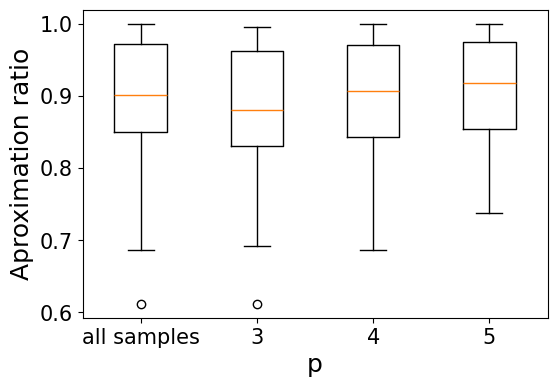

In [223]:
subdatas = [data.flatten()]
for index in range(0,3):
    aux = np.array([])
    for index2 in range(0,21,3):
        aux=np.concatenate((aux,data[index+index2]))
    subdatas.append(aux)

means = [np.mean(subdata, axis=0) for subdata in subdatas]

plt.figure(figsize=(6, 4))
categories =  ['all samples',3,4,5]


boxplot_stats = plt.boxplot(subdatas,labels=categories,usermedians=means)

plt.xlabel('p')
plt.ylabel('Aproximation ratio')

plt.show()

In [224]:
num_categories =len(categories)
statistics = np.zeros((num_categories, 5))  
for i in range(num_categories):
    # Boxplot stats
    box = boxplot_stats['boxes'][i].get_ydata()
    whiskers = boxplot_stats['whiskers'][2*i:2*i+2]
    means = boxplot_stats['medians'][i].get_ydata()
    caps = boxplot_stats['caps'][2*i:2*i+2]
    
    # Agregar estadísticas
    statistics[i, 0] = round(means[1],3)  # Mediana
    statistics[i, 1] = round(box[0],3)    # 25th percentile
    statistics[i, 2] =round(box[2],3)      # 75th percentile
    statistics[i, 3] = round(whiskers[0].get_ydata()[1],3)  # Bigote inferior
    statistics[i, 4] = round(whiskers[1].get_ydata()[1],3) # Bigote superior

In [225]:
column_names = ['mean','q1','q3','min.','max.']
df = pd.DataFrame(statistics[1:][:],columns=column_names)
df.insert(0,'p',[3,4,5])
df.to_csv('results/csvs/approximation_ratio/approximation_ratio_per_p.csv')

Finally, the following is an histogram of the complete $105$ sample set.

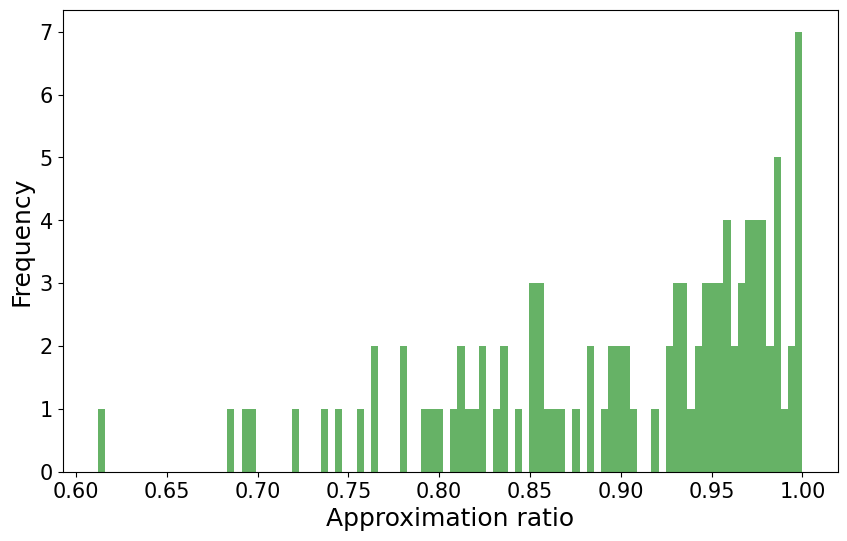

In [226]:
aux_data = data.flatten() 
n_bars=len(set(aux_data))
# Calculate mean and standard deviation from the dataset
mean = np.mean(aux_data)
std_dev = np.std(aux_data)

# Plot histogram of the dataset
plt.figure(figsize=(10, 6))
plt.hist(aux_data, bins=n_bars, density=False, alpha=0.6, color='g', label='Data Histogram')

# Plot the Gaussian curve
plt.xlabel('Approximation ratio')
plt.ylabel('Frequency')
plt.show()

### Optimizer's function evaluation

In [227]:
q_results = []
structured_fevs = []

instances_indexes = range(5)
for file_index,(filename,data2) in enumerate(files.items()):
    q_results.append([])
    structured_fevs.append([])
    
    for instance_index in instances_indexes:
        q_result =  QAOAResult.from_dict(data2[str(instance_index)]['result'])
        q_results[file_index].append(
            q_result
        )
        structured_fevs[file_index].append(q_result.evals['number_of_evals'])
structured_fevs = np.array(structured_fevs)

C:\Users\Adriano\AppData\Local\Temp\ipykernel_4020\3170978063.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(np.arange(first_files)[j] * category_width  + i * bar_width / num_samples_per_file,  # Desplazamiento de los puntos


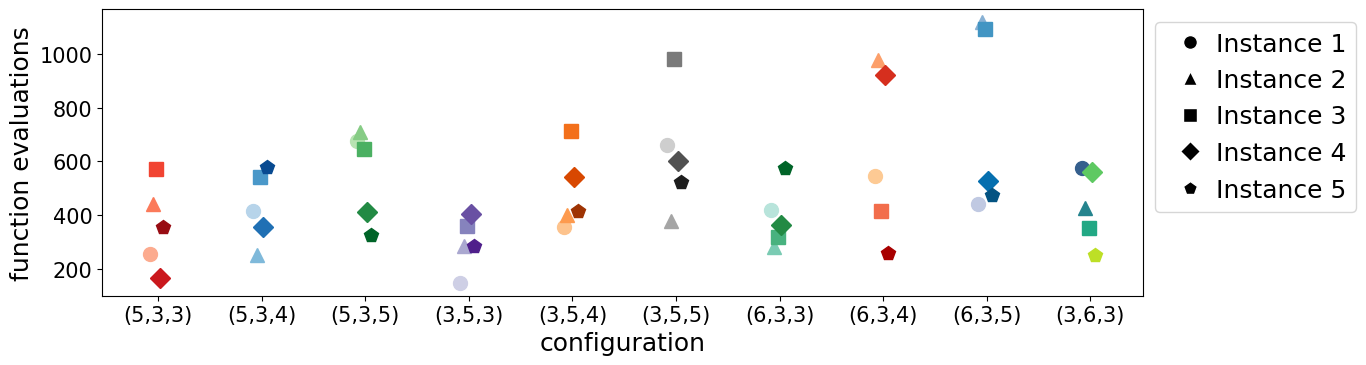

C:\Users\Adriano\AppData\Local\Temp\ipykernel_4020\3170978063.py:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(np.arange(last_files)[j] * category_width  + i * bar_width / num_samples_per_file,


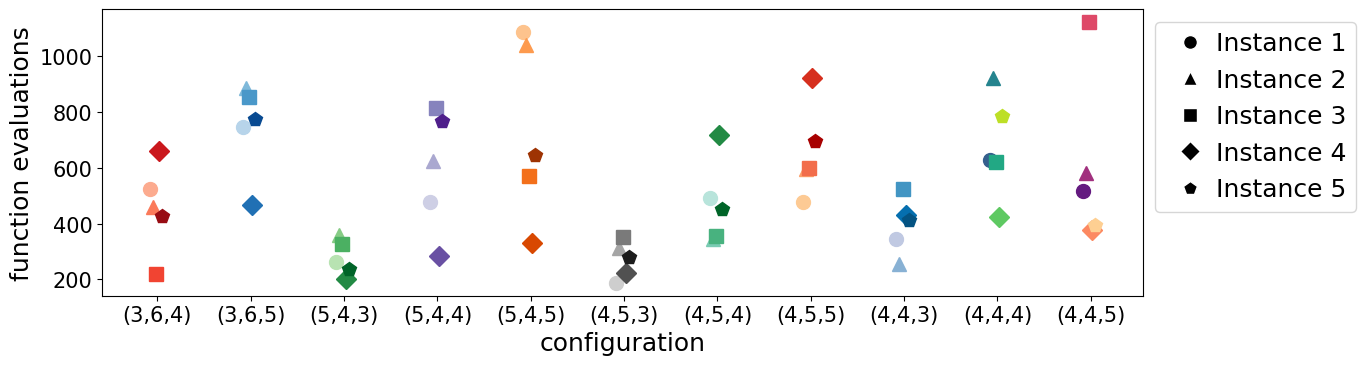

In [199]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(14, 4))
markers = ['o', '^', 's', 'D', 'p']  
linestyles = ['-', '--', '-.', ':']  
bar_width = 0.5
category_width = 3  

xlabel = 'configuration'
ylabel = 'function evaluations'
title = 'Approximation ratio for the JRP instances of all configurations'

# Plot bars for each group
for i in range(num_samples_per_file):
    for j in range(0,first_files):
        ax.plot(np.arange(first_files)[j] * category_width  + i * bar_width / num_samples_per_file,  # Desplazamiento de los puntos
            structured_fevs[j, i],
            'o', 
            color=colors[j][i],
            marker=markers[i],
            markersize=10,
            label=f'Group {i+1}')

# Add labels, title, and legend
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
legend_elements = [plt.Line2D([0], [0], marker=markers[i], color='w', label=f'Instance {i+1}', 
                              markerfacecolor='k', markersize=10) for i in range(num_samples_per_file)]
ax.legend(handles=legend_elements,  loc='upper left', bbox_to_anchor=(1, 1),handletextpad=0.01)
plt.xticks(np.arange(first_files) * category_width  + bar_width / 2, labels=[f'{configurations_names[i]}' for i in range(first_files)])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 4))
for i in range(num_samples_per_file):
    for j in range(last_files):
        ax.plot(np.arange(last_files)[j] * category_width  + i * bar_width / num_samples_per_file, 
            structured_fevs[first_files+j, i],
            'o', 
            color=colors[j][i],
            marker=markers[i],
            markersize=10,
            label=f'Group {i+1}')

# Add labels, title, and legend
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend(handles=legend_elements,  loc='upper left', bbox_to_anchor=(1, 1),handletextpad=0.01)


plt.xticks(np.arange(last_files) * category_width  + bar_width / 2, [f'{configurations_names[i]}' for i in  range(last_files-1,nums_files)])
#ax.set_yticks(np.arange(0, 1.1, 0.1) )
plt.tight_layout()
plt.show()

In [228]:
column_names = ['Instance 1', 'Instance 2', 'Instance 3', 'Instance 4', 'Instance 5']
df = pd.DataFrame(structured_fevs,columns=column_names)
df.insert(0,'configuration',configurations_names)
#df.to_csv('results/csvs/function_evaluations/function_evaluations_per_configuration.csv')

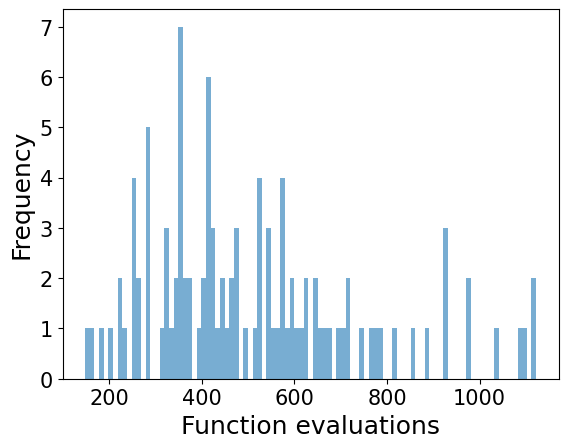

In [229]:
fevs = []
for conf in q_results:
    for res in conf:
        fevs.append(res.evals['number_of_evals'])
n_bars = len(set(fevs))
# Step 1: Plot frequency histogram
count, bins, ignored = plt.hist(fevs, bins=n_bars, density=False, alpha=0.6,label='histogram')
plt.xlabel('Function evaluations')
plt.ylabel('Frequency')

# Step 2: Fit a normal distribution to the data
mu, std = norm.fit(fevs)

# Step 3: Plot the Gaussian curve scaled to match the histogram
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# Scale the Gaussian curve by the total number of data points and the width of the bins
bin_width = bins[1] - bins[0]
p_scaled = p * len(fevs) * bin_width

#plt.plot(x, p_scaled, 'k', linewidth=2,label='gaussian fit')

textstr = f'Mean = {mu:.2f}\nStd Dev = {std:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#plt.text(xmax * 0.7, p_scaled.max() * 0.8, textstr, fontsize=12, bbox=props)


#plt.legend()

#plt.grid(True)
plt.show()

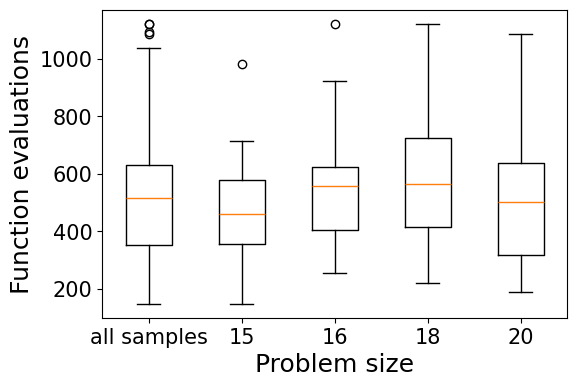

In [230]:
subfevs = np.array(fevs[:90])
subfevs = subfevs.reshape((3, 30)).tolist()
subfevs.insert(1,fevs[90:])
subfevs.insert(0,fevs)

means = [np.mean(sbf, axis=0) for sbf in subfevs]

plt.figure(figsize=(6, 4))
categories =  ['all samples',15,16,18,20]

plt.xlabel('Problem size')
plt.ylabel('Function evaluations')

boxplot_stats = plt.boxplot(subfevs,labels=categories,usermedians=means)
plt.show()

In [231]:
num_categories =len(categories)
statistics = np.zeros((num_categories, 5))  
for i in range(num_categories):
    # Boxplot stats
    box = boxplot_stats['boxes'][i].get_ydata()
    whiskers = boxplot_stats['whiskers'][2*i:2*i+2]
    means = boxplot_stats['medians'][i].get_ydata()
    caps = boxplot_stats['caps'][2*i:2*i+2]
    
    # Agregar estadísticas
    statistics[i, 0] = round(means[1],3)  # Mediana
    statistics[i, 1] = round(box[0],3)    # 25th percentile
    statistics[i, 2] =round(box[2],3)      # 75th percentile
    statistics[i, 3] = round(whiskers[0].get_ydata()[1],3)  # Bigote inferior
    statistics[i, 4] = round(whiskers[1].get_ydata()[1],3) # Bigote superior


In [233]:
column_names = ['mean','q1','q3','min.','max.']
df = pd.DataFrame(statistics[1:][:],columns=column_names)
df.insert(0,'problem size',[15,16,18,20])
df.to_csv('results/csvs/function_evaluations/function_evaluations_per_problem_size.csv')

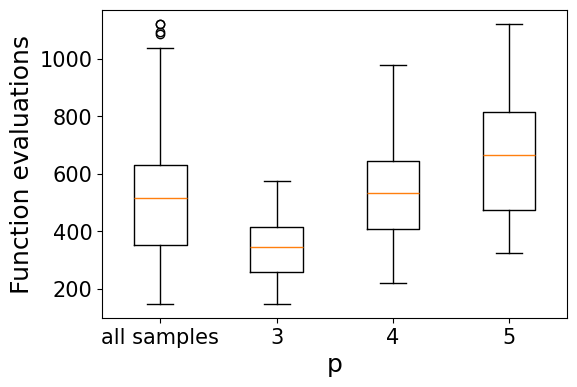

In [234]:
#subdatas = [data.flatten()]
subfevs = [fevs]
for index in range(0,3):
    aux = np.array([])
    for index2 in range(0,21,3):
        aux=np.concatenate((aux,structured_fevs[index+index2]))
    subfevs.append(aux)

means = [np.mean(sbf, axis=0) for sbf in subfevs]

plt.figure(figsize=(6, 4))
categories =  ['all samples',3,4,5]

plt.xlabel('p')
plt.ylabel('Function evaluations')

boxplot_stats = plt.boxplot(subfevs,labels=categories,usermedians=means)
plt.show()


In [235]:
num_categories =len(categories)
statistics = np.zeros((num_categories, 5))  
for i in range(num_categories):
    # Boxplot stats
    box = boxplot_stats['boxes'][i].get_ydata()
    whiskers = boxplot_stats['whiskers'][2*i:2*i+2]
    means = boxplot_stats['medians'][i].get_ydata()
    caps = boxplot_stats['caps'][2*i:2*i+2]
    
    # Agregar estadísticas
    statistics[i, 0] = round(means[1],3)  # Mediana
    statistics[i, 1] = round(box[0],3)    # 25th percentile
    statistics[i, 2] =round(box[2],3)      # 75th percentile
    statistics[i, 3] = round(whiskers[0].get_ydata()[1],3)  # Bigote inferior
    statistics[i, 4] = round(whiskers[1].get_ydata()[1],3) # Bigote superior


In [238]:
column_names = ['mean','q1','q3','min.','max.']
df = pd.DataFrame(statistics[1:][:],columns=column_names)
df.insert(0,'problem size',[3,4,5])
df.to_csv('results/csvs/function_evaluations/function_evaluations_per_p.csv')

### Ising cost differences

In [72]:
q_results = []
ising_cost_differences = []

instances_indexes = range(5)
for file_index,(filename,data2) in enumerate(files.items()):
    q_results.append([])
    ising_cost_differences.append([])
    
    for instance_index in instances_indexes:
        #q_result =  QAOAResult.from_dict(data2[str(instance_index)]['result'])
        # q_results[file_index].append(
        #      q_result
        # )
        ising_cost_differences[file_index].append(data2[str(instance_index)]['ising_cost_difference'])
ising_cost_differences = np.array(ising_cost_differences)



C:\Users\Adriano\AppData\Local\Temp\ipykernel_4020\3847117481.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(np.arange(first_files)[j] * category_width  + i * bar_width / num_samples_per_file,  # Desplazamiento de los puntos


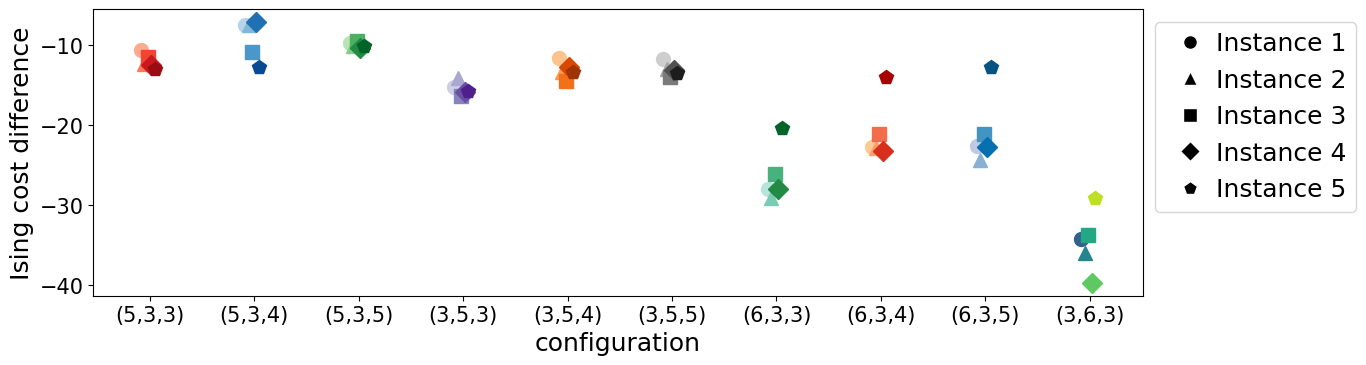

C:\Users\Adriano\AppData\Local\Temp\ipykernel_4020\3847117481.py:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(np.arange(last_files)[j] * category_width  + i * bar_width / num_samples_per_file,


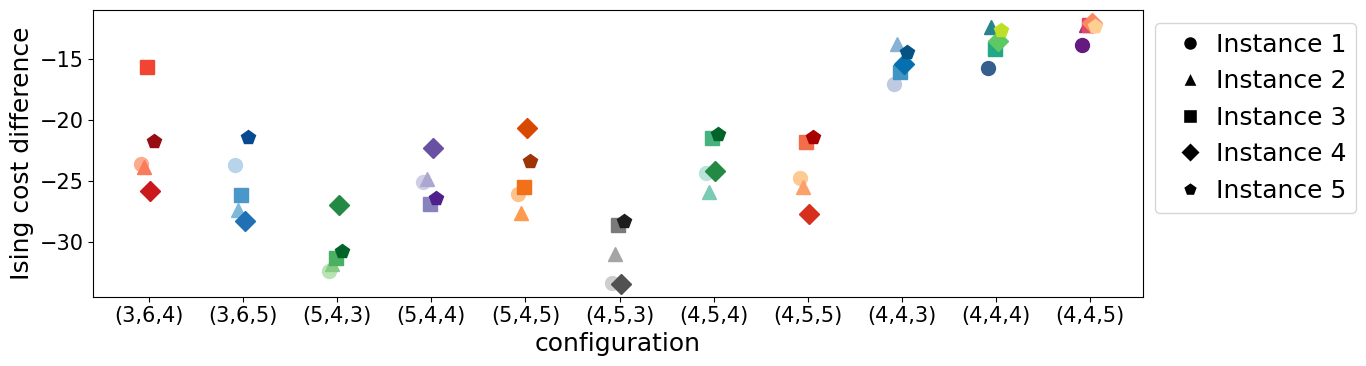

In [73]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(14, 4))
markers = ['o', '^', 's', 'D', 'p']  
linestyles = ['-', '--', '-.', ':']  
bar_width = 0.5
category_width = 3  

xlabel = 'configuration'
ylabel = 'Ising cost difference'
title = 'Ising cost difference for the JRP instances of all configurations'

# Plot bars for each group
for i in range(num_samples_per_file):
    for j in range(0,first_files):
        ax.plot(np.arange(first_files)[j] * category_width  + i * bar_width / num_samples_per_file,  # Desplazamiento de los puntos
            ising_cost_differences[j, i],
            'o', 
            color=colors[j][i],
            marker=markers[i],
            markersize=10,
            label=f'Group {i+1}')

# Add labels, title, and legend
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
legend_elements = [plt.Line2D([0], [0], marker=markers[i], color='w', label=f'Instance {i+1}', 
                              markerfacecolor='k', markersize=10) for i in range(num_samples_per_file)]
ax.legend(handles=legend_elements,  loc='upper left', bbox_to_anchor=(1, 1),handletextpad=0.01)
plt.xticks(np.arange(first_files) * category_width  + bar_width / 2, labels=[f'{configurations_names[i]}' for i in range(first_files)])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 4))
for i in range(num_samples_per_file):
    for j in range(last_files):
        ax.plot(np.arange(last_files)[j] * category_width  + i * bar_width / num_samples_per_file, 
            ising_cost_differences[first_files+j, i],
            'o', 
            color=colors[j][i],
            marker=markers[i],
            markersize=10,
            label=f'Group {i+1}')

# Add labels, title, and legend
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend(handles=legend_elements,  loc='upper left', bbox_to_anchor=(1, 1),handletextpad=0.01)


plt.xticks(np.arange(last_files) * category_width  + bar_width / 2, [f'{configurations_names[i]}' for i in  range(last_files-1,nums_files)])
#ax.set_yticks(np.arange(0, 1.1, 0.1) )
plt.tight_layout()
plt.show()

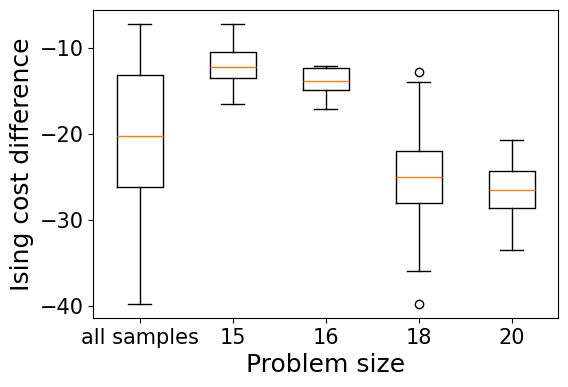

In [74]:
aux = ising_cost_differences.flatten()
diffs = np.array(aux[:90])
diffs = diffs.reshape((3, 30)).tolist()
diffs.insert(1,aux[90:])
diffs.insert(0,aux)

means = [np.mean(sbf, axis=0) for sbf in diffs]

plt.figure(figsize=(6, 4))
categories =  ['all samples',15,16,18,20]

plt.xlabel('Problem size')
plt.ylabel('Ising cost difference')

plt.boxplot(diffs,labels=categories,usermedians=means)
plt.show()

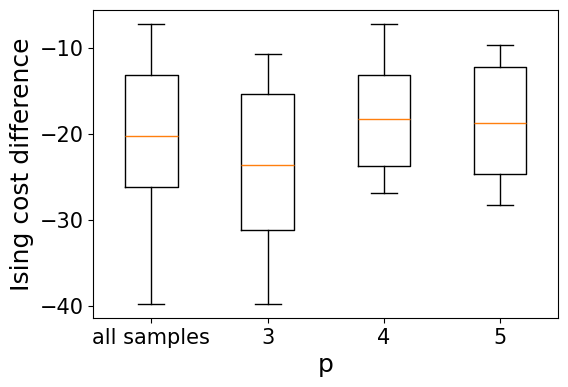

In [75]:
#subdatas = [data.flatten()]
diffs = [aux]
for index in range(0,3):
    aux2 = np.array([])
    for index2 in range(0,21,3):
        aux2=np.concatenate((aux2,ising_cost_differences[index+index2]))
    diffs.append(aux2)
means = [np.mean(sbf, axis=0) for sbf in diffs]

plt.figure(figsize=(6, 4))
categories =  ['all samples',3,4,5]

plt.xlabel('p')
plt.ylabel('Ising cost difference')

plt.boxplot(diffs,labels=categories,usermedians=means)
plt.show()


### Standard gain differences

In [76]:
q_results = []
standard_gain_differences = []

instances_indexes = range(5)
for file_index,(filename,data2) in enumerate(files.items()):
    q_results.append([])
    standard_gain_differences.append([])
    
    for instance_index in instances_indexes:
        #q_result =  QAOAResult.from_dict(data2[str(instance_index)]['result'])
        # q_results[file_index].append(
        #      q_result
        # )
        standard_gain_differences[file_index].append(data2[str(instance_index)]['standard_gain_difference'])
standard_gain_differences = np.array(standard_gain_differences)

C:\Users\Adriano\AppData\Local\Temp\ipykernel_4020\1460535571.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(np.arange(first_files)[j] * category_width  + i * bar_width / num_samples_per_file,  # Desplazamiento de los puntos


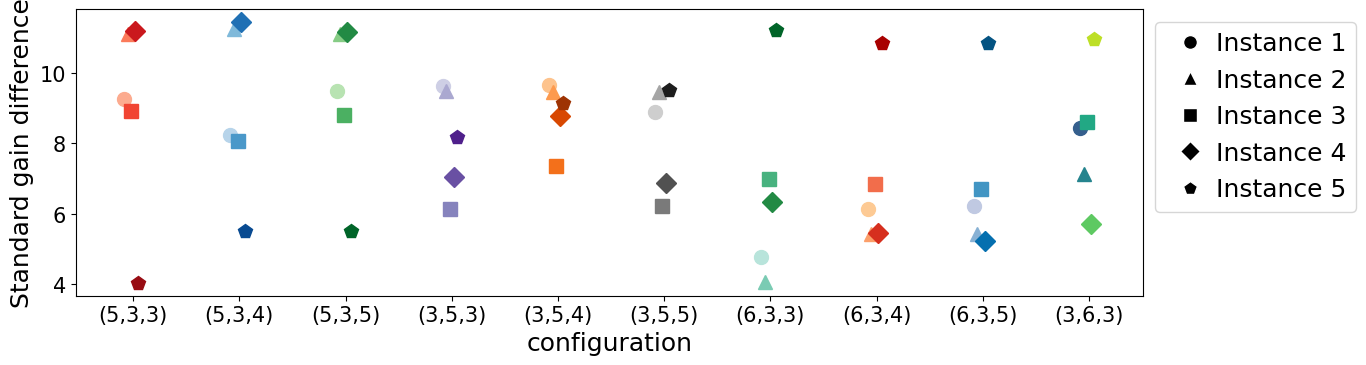

C:\Users\Adriano\AppData\Local\Temp\ipykernel_4020\1460535571.py:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(np.arange(last_files)[j] * category_width  + i * bar_width / num_samples_per_file,


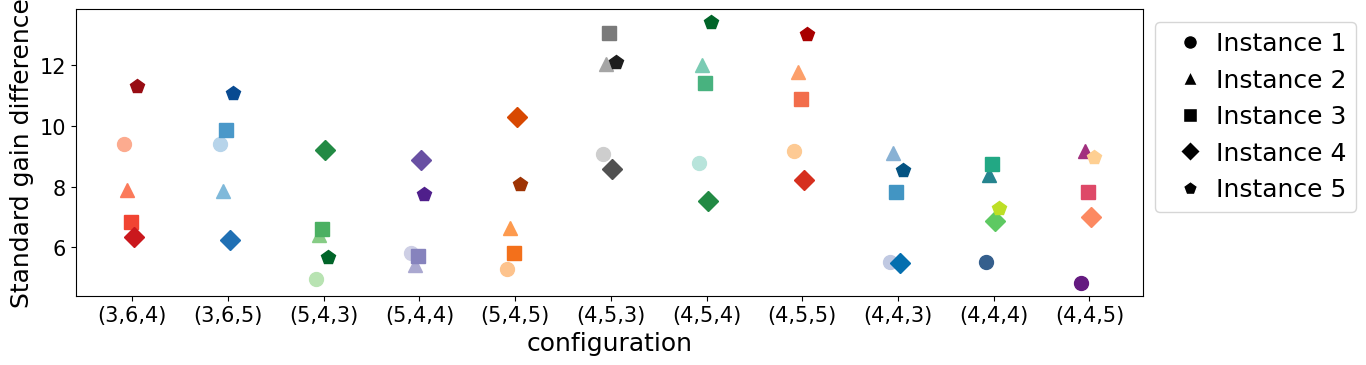

In [77]:
# Create a bar plot
fig, ax = plt.subplots(figsize=(14, 4))
markers = ['o', '^', 's', 'D', 'p']  
linestyles = ['-', '--', '-.', ':']  
bar_width = 0.5
category_width = 3  

xlabel = 'configuration'
ylabel = 'Standard gain difference'
title = 'Standard gain difference for the JRP instances of all configurations'

# Plot bars for each group
for i in range(num_samples_per_file):
    for j in range(0,first_files):
        ax.plot(np.arange(first_files)[j] * category_width  + i * bar_width / num_samples_per_file,  # Desplazamiento de los puntos
            standard_gain_differences[j, i],
            'o', 
            color=colors[j][i],
            marker=markers[i],
            markersize=10,
            label=f'Group {i+1}')

# Add labels, title, and legend
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
legend_elements = [plt.Line2D([0], [0], marker=markers[i], color='w', label=f'Instance {i+1}', 
                              markerfacecolor='k', markersize=10) for i in range(num_samples_per_file)]
ax.legend(handles=legend_elements,  loc='upper left', bbox_to_anchor=(1, 1),handletextpad=0.01)
plt.xticks(np.arange(first_files) * category_width  + bar_width / 2, labels=[f'{configurations_names[i]}' for i in range(first_files)])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 4))
for i in range(num_samples_per_file):
    for j in range(last_files):
        ax.plot(np.arange(last_files)[j] * category_width  + i * bar_width / num_samples_per_file, 
            standard_gain_differences[first_files+j, i],
            'o', 
            color=colors[j][i],
            marker=markers[i],
            markersize=10,
            label=f'Group {i+1}')

# Add labels, title, and legend
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend(handles=legend_elements,  loc='upper left', bbox_to_anchor=(1, 1),handletextpad=0.01)


plt.xticks(np.arange(last_files) * category_width  + bar_width / 2, [f'{configurations_names[i]}' for i in  range(last_files-1,nums_files)])
#ax.set_yticks(np.arange(0, 1.1, 0.1) )
plt.tight_layout()
plt.show()

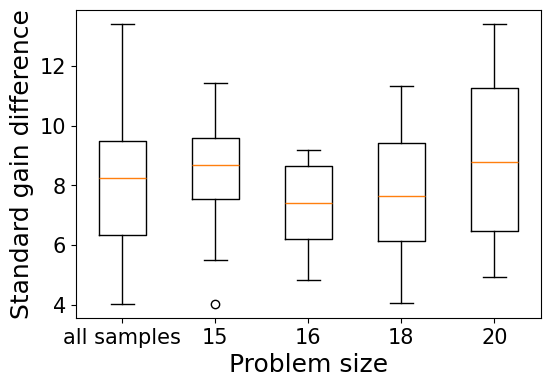

In [84]:
aux = standard_gain_differences.flatten()
diffs = np.array(aux[:90])
diffs = diffs.reshape((3, 30)).tolist()
diffs.insert(1,aux[90:])
diffs.insert(0,aux)

means = [np.mean(sbf, axis=0) for sbf in diffs]

plt.figure(figsize=(6, 4))
categories =  ['all samples',15,16,18,20]

plt.xlabel('Problem size')
plt.ylabel('Standard gain difference')

plt.boxplot(diffs,labels=categories,usermedians=means)
plt.show()

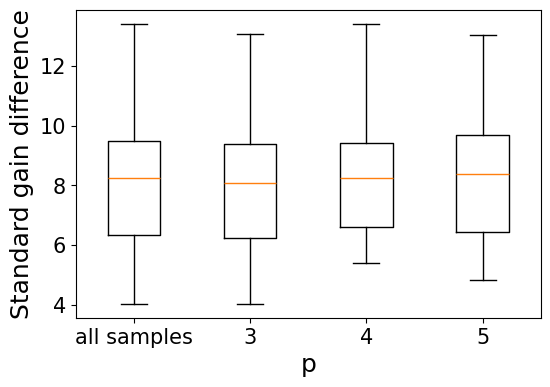

In [86]:
#subdatas = [data.flatten()]
diffs = [aux]
for index in range(0,3):
    aux2 = np.array([])
    for index2 in range(0,21,3):
        aux2=np.concatenate((aux2,standard_gain_differences[index+index2]))
    diffs.append(aux2)
means = [np.mean(sbf, axis=0) for sbf in diffs]

plt.figure(figsize=(6, 4))
categories =  ['all samples',3,4,5]

plt.xlabel('p')
plt.ylabel('Standard gain difference')

plt.boxplot(diffs,labels=categories,usermedians=means)
plt.show()


### Probability of measuring with a minimal approximation ratio and number of shots

In this section, the idea is to draw some contour plots, where a point (X,Y,Z), where Z is representes a color depth, means the following:

"After doing Y measures of the ansatz with the optimized parameters,  there is a probability ofZY that one of that measured solutions ha   an approximation ratio of X or bigger"

The following cells do the preprocessing for creating the 3-tensor needed for this plot. Since this has alredy been done, the preprocessing is desactivated.

In [16]:
PREPROCESS = False

In [17]:
if PREPROCESS:
    directory1 = './results/contour_plots'
    
    for key in list(keys):
        directory2 = directory1+'/'+str(key)
        if not os.path.exists(directory2):
            os.makedirs(directory2)                           
        for index in range(5):
            directory3 = directory2 +'/'+str(index)+'.json'
            tensor3_for_approximation_ratio(files[key][str(index)],size=5000,n_measures=1000,directory=directory3,plot=False)

We read each preprocessed file into the notebook

In [18]:
axises = {}
gral_directory = './results/contourf_plots'

for key in keys:
    directory = gral_directory + '/' + str(key) 
    axises[str(key)] = []
    for file in os.listdir(directory):
        if file.endswith('.json'):
            full_path = os.path.join(directory, file)
            with open(full_path, 'r', encoding='utf-8') as f:
                axises[str(key)].append(json.load(f))

In [19]:
CREATE_IMAGES = False

Create each image individually and then in a global image. This has alredy been done.

In [20]:
if CREATE_IMAGES:
    for i,key in enumerate(keys):
        instances = axises[str(key)]
        for j,instance in enumerate(instances):
            X,Z,Y = instance.values()
            dir = 'results/contourf_plots/'+str(key)+'/'+str(j)+'.png'
            make_contourf_plot(X,Z,Y,directory=dir)
            #plt.show()
            plt.close()

In [21]:
if CREATE_IMAGES:
    fig, axs = plt.subplots(nrows=21, ncols=5, figsize=(40, 100))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    for i,key in enumerate(keys):
        instances = axises[str(key)]
        for j,instance in enumerate(instances):
            X,Z,Y = instance.values()
            make_contourf_plot(X,Z,Y,ax=axs[i,j])
    
    col_labels = [f'instance {i+1}' for i in range(5)]
    for j, label in enumerate(col_labels):
        axs[0, j].set_title(label, pad=10,fontsize=20)
        
    row_labels = [f'Row {i}' for i in range(21)]
    row_labels = [str(i[5:17]+'\n'+str(i[18:])) for i in keys]
    row_labels = ['configuration\n'+str(i) for i in configurations_names]
    for i, label in enumerate(row_labels):
        axs[i, 0].set_ylabel(label, rotation=45, labelpad=40,fontsize=18)
    fig.savefig('results/contourf_plots/imgs.png', bbox_inches='tight')
    #plt.show()
    plt.close()

In [25]:
'''X,Z,Y = axises['conf_jrpInitConf0_circuitConf0'][2].values()
print(len(Z))
make_contourf_plot(X,Z,Y)
'''

"X,Z,Y = axises['conf_jrpInitConf0_circuitConf0'][2].values()\nprint(len(Z))\nmake_contourf_plot(X,Z,Y)\n"

The complete global images for the 105 instances is shown below.

## Measurements needed for ensure a minimal approximation ratio with a particular probability

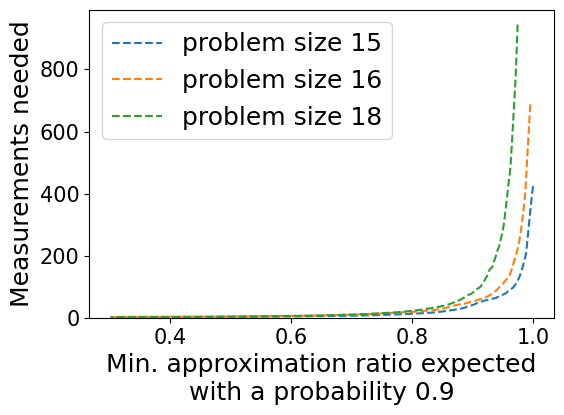

In [22]:
subkeys = []
for index in range(0,len(data)-6,6):
    subkeys.append([keys[index],keys[index+1],keys[index+2],keys[index+3],keys[index+4],keys[index+5]])
#subkeys.append([keys[18],keys[19],keys[20]])

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['problem size 15','problem size 16','problem size 18','problem size 20']
for index,sks in enumerate(subkeys):
    Xs=[]
    Zs=[]
    Ys=[]
    for sk in sks: 
        Xs = Xs+[axises[str(sk)][i]['X'] for i in range(5)]
        Zs = Zs+[axises[str(sk)][i]['Z'] for i in range(5)]
        Ys = Ys+[axises[str(sk)][i]['Y'] for i in range(5)]
    make_average_contour_plot(Xs,Zs,Ys,probability=0.9,ax=ax,plot_label=labels[index])
#plt.show()
plt.show()

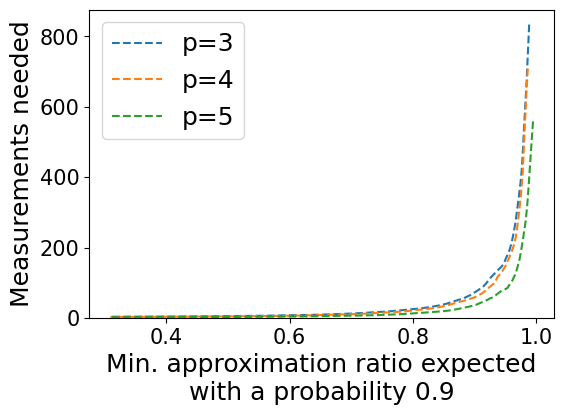

In [27]:
subkeys = []
for index in range(0,3):
    aux = []
    for index2 in range(0,21,3):
        aux.append(keys[index+index2])
    subkeys.append(aux)
fig, ax = plt.subplots(figsize=(6, 4))
labels = ['p=3','p=4','p=5']
for index,sks in enumerate(subkeys):
    Xs=[]
    Zs=[]
    Ys=[]
    for sk in sks: 
        Xs = Xs+[axises[str(sk)][i]['X'] for i in range(5)]
        Zs = Zs+[axises[str(sk)][i]['Z'] for i in range(5)]
        Ys = Ys+[axises[str(sk)][i]['Y'] for i in range(5)]
    make_average_contour_plot(Xs,Zs,Ys,probability=0.9,ax=ax,plot_label=labels[index])
#plt.show()
plt.show()